# In-Class Group Exercise

In [633]:
# Group Review Exercise
import pandas as pd

%matplotlib inline

# Other imports as you see fit (sklearn, etc)

df = pd.read_csv('https://github.com/ga-students/DAT-NYC-37/raw/master/lessons/lesson-11/datasets/titanic.csv')

# Print a basic summary of the data
print df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
ticket      891 non-null object
fare        891 non-null float64
cabin       204 non-null object
embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB
None


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
import os


os.getcwd()

'/Users/Aerlinger/Dropbox/GeneralAssembly/DAT-NYC-37/lessons/lesson-13'

# Your objective:

*Given a set of features for a passenger (as defined in the dataset) predict whether or not they will survive on the Titanic.*


1. Perform any necessary conditioning or cleaning to the data
2. Define the train/test split
3. Choose and Define a model with all relevant parameters for that model
4. Fit the model
5. Determine the precision, recall, and F1 score for this model on the *training* dataset
6. Predict whether passengers with the  following features survive:

```
     pclass     sex   age  sibsp  parch    ticket      fare cabin embarked
          3  female   NaN      8      2   CA.2343   69.5500   NaN        S
          3    male   NaN      0      0    349214    7.8958   NaN        S
          3    male   NaN      0      0    349253    7.8958   NaN        C
          1    male  44.0      2      0     19928   90.0000   C78        Q
          2    male  31.0      0      0    244270   13.0000   NaN        S
          1  female  31.0      0      2     36928  164.8667    C7        S
          3  female  38.0      1      5    347077   31.3875   NaN        S
          2    male  30.0      0      0     28228   13.0000   NaN        S
          1    male   NaN      0      0   PC17757  227.5250   NaN        C
          2  female  17.0      0      0    SC1748   12.0000   NaN        C
```

### Tip: use copy the above block and use pd.read_clipboard() to create a dataframe from the contents of your current clipboard

---

# A Possible Solution:

### Step 1: Perform any necessary conditioning or cleaning to the data

In [646]:
def column_transformations(dataframe):
    is_male       = df['sex'].replace({'male': 1, 'female': 0})
    estimated_age = df['age'].fillna(df['age'].mean())
    
    is_male.rename("is_male", inplace=True)
    estimated_age.rename("estimated_age", inplace=True)

    df_temp = pd.concat([dataframe, is_male, estimated_age], axis=1).drop(['sex', 'age'], axis=1)
    
    return pd.get_dummies(df_temp, columns=['pclass', 'embarked'])

df_model = column_transformations(df)

df_model.head(3)

,survived,name,sibsp,parch,ticket,fare,cabin,is_male,estimated_age,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
0,0,"Braund, Mr. Owen Harris",1,0,A/5 21171,7.2500,NaN,1,22.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,71.2833,C85,0,38.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,7.9250,NaN,0,26.0,0.0,0.0,1.0,0.0,0.0,1.0


In [619]:
X = df_model.drop(['survived', 'name', 'ticket', 'cabin'], axis=1)
y = df_model['survived']  

print "Features:"
X.info();

Features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
sibsp            891 non-null int64
parch            891 non-null int64
fare             891 non-null float64
is_male          891 non-null int64
estimated_age    891 non-null float64
pclass_1         891 non-null float64
pclass_2         891 non-null float64
pclass_3         891 non-null float64
embarked_C       891 non-null float64
embarked_Q       891 non-null float64
embarked_S       891 non-null float64
dtypes: float64(8), int64(3)
memory usage: 76.6 KB


---

### Step 2: Define the Train/Test Split

*We're just using a simple train/test split here. We can later use KFold for more robust modeling and validation later*

In [620]:
from sklearn import tree, cross_validation, linear_model, metrics

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1)

---

### Step 3 & 4: Choose and Define a model with all relevant parameters for that model & fit the model

*We'll define a simple function to help us display model results*

In [621]:
# This is just a utility method to help print a summary of the results
def format_model_results(sklearn_model, X_train, X_test, y_train, y_test):
    # Get the model's class name (E.g. LogisticRegression, KNearestNeighbor, etc.) and store it to a string
    model_class_name = sklearn_model.__class__.__name__  
    
    y_test_pred   = sklearn_model.predict(X_test)
    y_train_pred  = sklearn_model.predict(X_train)

    precision_score = metrics.precision_score(y_test_pred, y_test)
    recall_score    = metrics.recall_score(y_test_pred, y_test)
    f1_score        = metrics.f1_score(y_test_pred, y_test)
    f1_score_train  = metrics.f1_score(y_train_pred, y_train)
    auc_score       = metrics.roc_auc_score(y_test_pred, y_test)
    
    return pd.DataFrame({
            "Precision": precision_score, 
            "Recall": recall_score, 
            "F1 score": f1_score, 
            "F1 score (train)": f1_score_train, 
            "AUC": auc_score
        }, index=[model_class_name])

### <span style="color: blue;">Logistic Regression</span>

In [608]:
# Try additional models
logreg_model = linear_model.LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [609]:
format_model_results(logreg_model, X_train, X_test, y_train, y_test)

,AUC,F1 score,F1 score (train),Precision,Recall
LogisticRegression,0.782461,0.720379,0.736111,0.66087,0.791667


### <span style="color: blue;">KNN</span>

In [610]:
from sklearn import neighbors

knn_model = neighbors.KNeighborsClassifier(n_neighbors=k)

knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=99, p=2,
           weights='uniform')

In [611]:
format_model_results(knn_model, X_train, X_test, y_train, y_test)

,AUC,F1 score,F1 score (train),Precision,Recall
KNeighborsClassifier,0.646709,0.454545,0.450142,0.347826,0.655738


### <span style="color: blue;">Decision Trees</span>

In [612]:
dectree_model = tree.DecisionTreeClassifier()

dectree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [613]:
format_model_results(dectree_model, X_train, X_test, y_train, y_test)

,AUC,F1 score,F1 score (train),Precision,Recall
DecisionTreeClassifier,0.752436,0.691589,0.98441,0.643478,0.747475


### <span style="color: blue;">Random Forest Classifier</span>

In [614]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators = 1000, max_features=None, oob_score=True, min_samples_leaf=5)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [615]:
format_model_results(rf_model, X_train, X_test, y_train, y_test)

,AUC,F1 score,F1 score (train),Precision,Recall
RandomForestClassifier,0.791338,0.69697,0.840855,0.6,0.831325


## Comparison

In [616]:
scores_df = pd.concat([
    format_model_results(logreg_model, X_train, X_test, y_train, y_test),
    format_model_results(knn_model, X_train, X_test, y_train, y_test),
    format_model_results(dectree_model, X_train, X_test, y_train, y_test),
    format_model_results(rf_model, X_train, X_test, y_train, y_test),
])

scores_df

,AUC,F1 score,F1 score (train),Precision,Recall
LogisticRegression,0.782461,0.720379,0.736111,0.660870,0.791667
KNeighborsClassifier,0.646709,0.454545,0.450142,0.347826,0.655738
DecisionTreeClassifier,0.752436,0.691589,0.984410,0.643478,0.747475
RandomForestClassifier,0.791338,0.696970,0.840855,0.600000,0.831325


### <span style="color: green; text-decoration: underline;">Note how simple it is to evaluate different models. Most of the work is in cleaning the data!</span>

---

# Solution Part II: Improving the model

Our best model above gives an AUC score of 0.8031. This is a good start, but there are plenty of steps we can take to improve our results:

2. **Feature Engineering:** We may be able to add "synthetic" information to our dataset by adding features from information already present. For instance, we discarded name, but perhaps we could get more information about a passenger by searching for keywords relating to honorifics and titles like 'Sir', 'Miss', 'Mrs', etc. This is called **feature engineering**

1. **Parameter Tuning:** Modifying various parameters of our models may improve performance. For instance, for our RandomForest model we can control the complexity of our model by modifying `num_estimators`, `min_samples_leaf`, `max_features`, etc... *(See: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)*

3. **Improved Cross Validation Techniques:** Because we're holding out 30% of our data for testing, we have less data samples on which to actually build our model. How can we address this?
> **Example:** Use K-Fold cross validation. A larger value of k will allow us to keep more of our data for training, but will require training the same model multiple times.

### Improvement 1: Feature Engineering

In our original analysis we dropped the `cabin`, `ticket`, and `name` columns. However, do these columns contain information that may improve our model?

We can apply our own intelligence to try to add information to the dataset which are not present in the original feature space. We call this *feature engineering*.

In [623]:
##
# Get first character of values in the cabin column
#    See: http://pandas.pydata.org/pandas-docs/stable/text.html?highlight=string
# 
# Example: get_title("Braund, Mr. Owen Harris")  # -> will return 'mr'
def get_title(name):
    titles = ['miss.','mrs.','master.','mr.','dr.','rev.','sir.','col.','lady.','archibald','major.','capt.']
    
    if name:
        for title in titles:
            if name.lower().find(title.lower()) > -1:
                return title.replace(".", "")

    return "none"

def add_engineered_features(dataframe):
    honorifics         = dataframe['name'].map(get_title)
    cabin_prefixes     = dataframe['cabin'].str.get(0)
    ticket_is_numeric  = dataframe['ticket'].str.isnumeric()
    ticket_starts_with = dataframe['ticket'].str.get(0)

    honorifics.rename('honorific', inplace=True)
    cabin_prefixes.rename('cabin_prefix', inplace=True)
    ticket_is_numeric.rename('ticket_is_numeric', inplace=True)
    ticket_starts_with.rename('ticket_starts_with', inplace=True)

    df_processed = pd.concat([dataframe, honorifics, cabin_prefixes, ticket_is_numeric, ticket_starts_with], axis=1)
    df_processed = pd.get_dummies(df_processed, columns=['honorific', 'cabin_prefix', 'ticket_starts_with'])

    return df_processed.drop(['name', 'cabin', 'ticket'], axis=1)

# Clean the data:
df_model = column_transformations(df)
df_model_improved = add_engineered_features(df_model)

X = df_model_improved.drop('survived', axis=1)
y = df_model_improved['survived']  


### Improvements 2 & 3: Evaluating the model with cross-validation and parameter tuning

In [625]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators = 500, max_features=None, oob_score=True, min_samples_leaf=5)

n_folds = 10

##
# `cross_val_score` is a way to train/test split AND compute a score in a single step.
#  It takes three required parameters:
#  1. The model (`model_rf`)
#  2. The dataset (`X`)
#  3. The target ('y')
#
#  Plus a bunch of optional params, but most commonly these will be:
#  - cv (integer): Number of cross-validations (i.e. folds) to perform. This is the same as K
#  - scoring method: e.g. ('roc_auc', 'f1_score')
#   See http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values
#
# See: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html
cv_score = cross_validation.cross_val_score(model_rf, X, y, cv=n_folds, scoring='roc_auc')

print "Avg AUC Score across %s folds: %s" % (n_folds, cv_score.mean())

Avg AUC Score across 10 folds: 0.884134793311


### Prediction

In [647]:
df_sample

,survived,name,sibsp,parch,ticket,fare,cabin,is_male,estimated_age,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S
607,1,"Daniel, Mr. Robert Williams",0,0,113804,30.5000,NaN,0,0,0,0,0,0,0,0
560,0,"Morrow, Mr. Thomas Rowan",0,0,372622,7.7500,NaN,0,0,0,0,0,0,0,0
410,0,"Sdycoff, Mr. Todor",0,0,349222,7.8958,NaN,0,0,0,0,0,0,0,0
838,1,"Chip, Mr. Chang",0,0,1601,56.4958,NaN,0,0,0,0,0,0,0,0
181,0,"Pernot, Mr. Rene",0,0,SC/PARIS 2131,15.0500,NaN,0,0,0,0,0,0,0,0
388,0,"Sadlier, Mr. Matthew",0,0,367655,7.7292,NaN,0,0,0,0,0,0,0,0
158,0,"Smiljanic, Mr. Mile",0,0,315037,8.6625,NaN,0,0,0,0,0,0,0,0
741,0,"Cavendish, Mr. Tyrell William",1,0,19877,78.8500,C46,0,0,0,0,0,0,0,0
312,0,"Lahtinen, Mrs. William (Anna Sylfven)",1,1,250651,26.0000,NaN,0,0,0,0,0,0,0,0
725,0,"Oreskovic, Mr. Luka",0,0,315094,8.6625,NaN,0,0,0,0,0,0,0,0


In [654]:
df_sample = df.sample(100)
df1 = column_transformations(df)

df_sample = pd.concat([df_sample['pclass'], df_sample['embarked'], df_sample.reindex(columns=df1.columns, fill_value=0)], axis=1)

In [641]:

df_model_improved = add_engineered_features(df_model)

X_sample = preprocess(df_sample)

print X_sample.shape
print X.shape

print X_sample.columns
print X.columns

AttributeError: 'float' object has no attribute 'lower'

In [599]:
cross_validation.cross_val_predict(model_rf, X)

ValueError: Expected array-like (array or non-string sequence), got None

In [598]:
model_rf.predict(X_sample)

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

## Analyzing the results on Kaggle

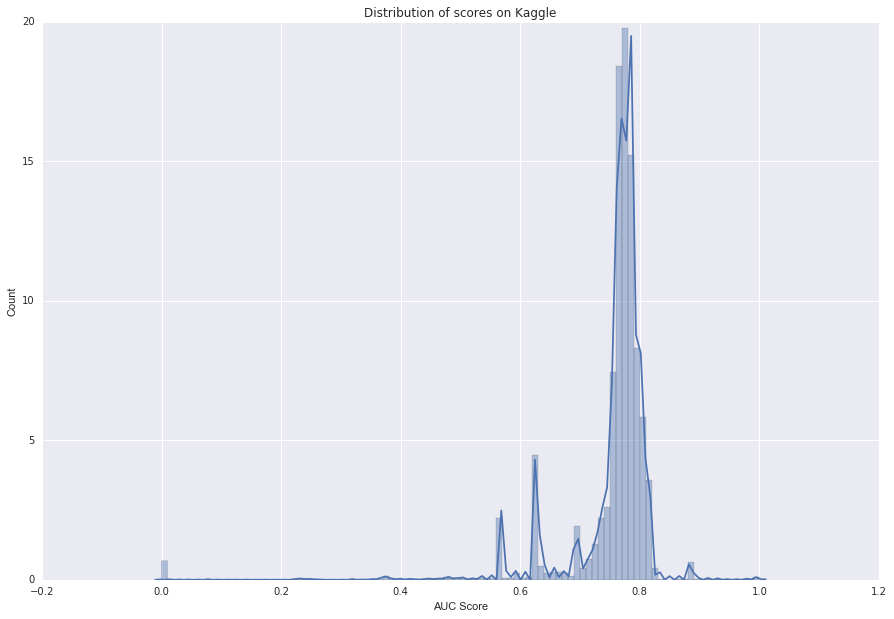

In [544]:
kaggle_scores = pd.read_csv('~/downloads/titanic_public_leaderboard.csv')

plt.figure(figsize=(15, 10))
ax = sns.distplot(kaggle_scores['Score'], bins=100)

ax.set_title("Distribution of scores on Kaggle")
ax.set_xlabel("AUC Score")
ax.set_ylabel("Count");